# HW09

## Exercises to practice unsupervised learning, clustering and PCA

### Setup

Run the following 2 cells to import all necessary libraries and helpers for this homework.

In [1]:
!wget -q https://github.com/DM-GY-9103-2024F-H/9103-utils/raw/main/src/data_utils.py
!wget -q https://github.com/DM-GY-9103-2024F-H/9103-utils/raw/main/src/image_utils.py
!wget -q https://github.com/DM-GY-9103-2024F-H/HW08/raw/main/HW08_utils.pyc

In [2]:
import matplotlib.pyplot as plt
import pandas as pd

from os import listdir, path
from sklearn.preprocessing import OrdinalEncoder

from data_utils import object_from_json_url
from data_utils import StandardScaler
from data_utils import KMeansClustering, GaussianClustering, SpectralClustering

from data_utils import PCA, RandomForestClassifier, SVC
from data_utils import classification_error, display_confusion_matrix

from image_utils import make_image, open_image

from HW08_utils import CamUtils

### Load Dataset

Let's load up the full [ANSUR](https://www.openlab.psu.edu/ansur2/) dataset that we looked at briefly in [Week 02](https://github.com/DM-GY-9103-2024F-H/WK02) and then again in [HW08](https://github.com/DM-GY-9103-2024F-H/HW08) last week.

This is the dataset that has anthropometric information about U.S. Army personnel.

In [3]:
# Load Dataset
ANSUR_FILE = "https://raw.githubusercontent.com/DM-GY-9103-2024F-H/9103-utils/main/datasets/json/ansur.json"
ansur_data = object_from_json_url(ANSUR_FILE)

# Look at first 2 records
ansur_data[:2]

[{'age': 18,
  'gender': 'F',
  'height': 66,
  'weight': 135,
  'span': 1699,
  'stature': 1645,
  'ear': {'breadth': 30, 'length': 61, 'protrusion': 20},
  'foot': {'breadth': 97, 'length': 243},
  'hand': {'breadth': 78, 'length': 182, 'palm': 108},
  'head': {'height': 243, 'circumference': 557}},
 {'age': 30,
  'gender': 'M',
  'height': 68,
  'weight': 207,
  'span': 1749,
  'stature': 1715,
  'ear': {'breadth': 35, 'length': 63, 'protrusion': 17},
  'foot': {'breadth': 100, 'length': 252},
  'hand': {'breadth': 87, 'length': 184, 'palm': 114},
  'head': {'height': 238, 'circumference': 560}}]

Let's load it into a `DataFrame`, like last week.

In [4]:
# Read into DataFrame
ansur_df = pd.json_normalize(ansur_data)
ansur_df.head()

,age,gender,height,weight,span,stature,ear.breadth,ear.length,ear.protrusion,foot.breadth,foot.length,hand.breadth,hand.length,hand.palm,head.height,head.circumference
0,18,F,66,135,1699,1645,30,61,20,97,243,78,182,108,243,557
1,30,M,68,207,1749,1715,35,63,17,100,252,87,184,114,238,560
2,27,M,67,121,1684,1657,36,59,24,92,251,84,180,103,239,516
3,20,M,73,185,1878,1828,36,60,21,104,280,95,201,124,270,582
4,33,M,76,150,1977,1883,39,65,27,101,271,90,194,113,254,559


### Unsupervised Learning

Let's pretend we are designing next-generation helmets with embedded over-the-ear headphones and we want to have a few options for sizes.

We could use clustering to see if there is a number of clusters that we can divide our population into, so each size covers a similar portion of the population.

We can follow similar steps to regression to create a clustering model that uses features about head and ear sizes:

1. Load dataset (done! 🎉)
2. Encode label features as numbers
3. Normalize the data
4. Separate the feature variables we want to consider (done below)
5. Pick a clustering algorithm
6. Determine number of clusters
7. Cluster data
8. Interpret results

For step $5$, it's fine to just pick an algorithm ahead of time to see what happens, but feel free to experiment and plot results for multiple clustering methods.

In [5]:
## Encode non-numerical features
ansur_encoder = OrdinalEncoder()
ansur_encoded = ansur_encoder.fit_transform(ansur_df[["gender"]].values)
ansur_df[["gender"]] = ansur_encoded

## Normalize the data
ansur_scaler = StandardScaler()
ansur_scaled_df = ansur_scaler.fit_transform(ansur_df)

In [6]:
## Separate the features we want to consider
ansur_features = ansur_scaled_df[["head.height", "head.circumference", "ear.length", "ear.breadth", "ear.protrusion"]]

KMeans distance error: 1.6507461891514719
Spectral distance error: 1.6584175265754844
Gaussian distance error: 1.67157938777427
KMeans likelihood error: -5.748639457181452
Spectral likelihood error: -5.732854569757381
Gaussian likelihood error: -5.728496638227457
KMeans balance error: 0.033571428571428585
Spectral balance error: 0.11696428571428576
Gaussian balance error: 0.037589285714285714


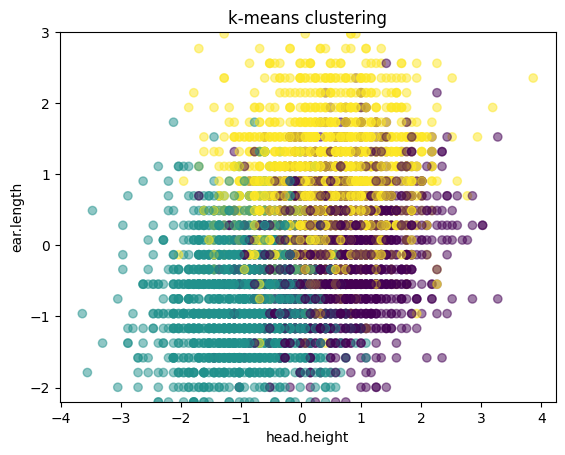

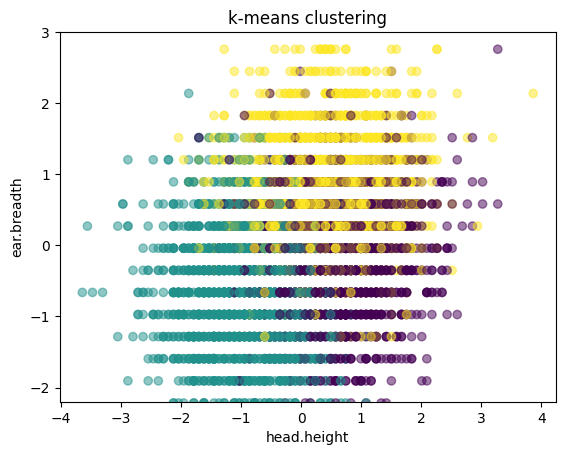

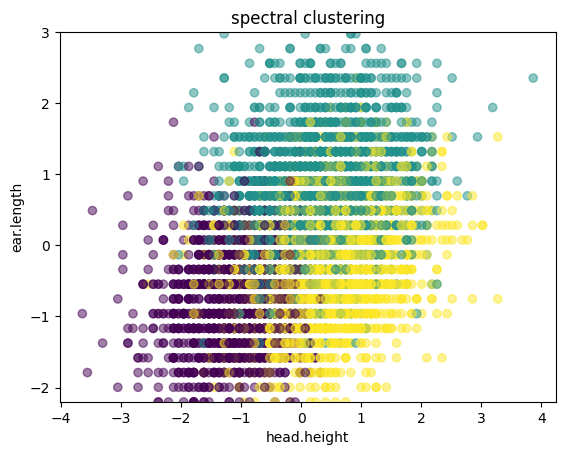

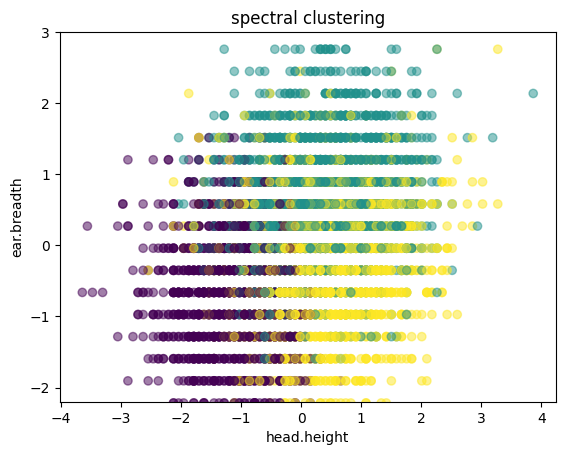

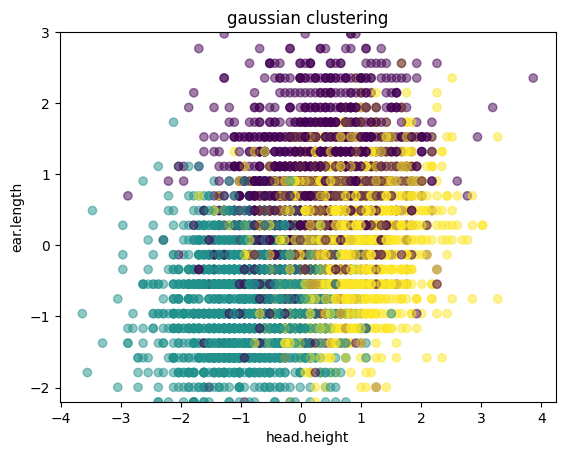

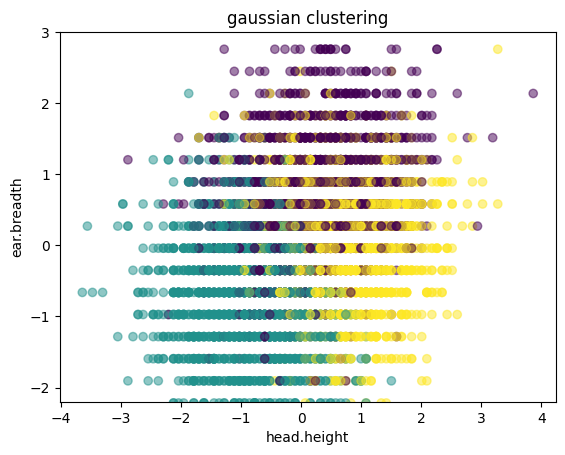

In [7]:
## Create Clustering model
n_clusters = 3
km_model = KMeansClustering(n_clusters=n_clusters)
sc_model = SpectralClustering(n_clusters = n_clusters)
gs_model = GaussianClustering(n_clusters=n_clusters)

## Run the model(s) on the data
km_predicted = km_model.fit_predict(ansur_features)
km_clusters = km_predicted["clusters"]

sc_predicted = sc_model.fit_predict(ansur_features)
sc_clusters = sc_predicted["clusters"]

gs_predicted = gs_model.fit_predict(ansur_features)
gs_clusters = gs_predicted["clusters"]

## Check errors
print("KMeans distance error:", km_model.distance_error())
print("Spectral distance error:", sc_model.distance_error())
print("Gaussian distance error:", gs_model.distance_error())

print("KMeans likelihood error:", km_model.likelihood_error())
print("Spectral likelihood error:", sc_model.likelihood_error())
print("Gaussian likelihood error:", gs_model.likelihood_error())

print("KMeans balance error:", km_model.balance_error())
print("Spectral balance error:", sc_model.balance_error())
print("Gaussian balance error:", gs_model.balance_error())

## Plot clusters as function of 2 or 3 variables
xl, yl, zl = "head.height", "ear.length", "ear.breadth"
x = ansur_scaled_df[xl]
y = ansur_scaled_df[yl]
z = ansur_scaled_df[zl]

plt.scatter(x, y, c=km_clusters, marker='o', linestyle='', alpha=0.5)
plt.title("k-means clustering")
plt.xlabel(xl)
plt.ylabel(yl)
plt.ylim([-2.2, 3])
plt.show()

plt.scatter(x, z, c=km_clusters, marker='o', linestyle='', alpha=0.5)
plt.title("k-means clustering")
plt.xlabel(xl)
plt.ylabel(zl)
plt.ylim([-2.2, 3])
plt.show()

plt.scatter(x, y, c=sc_clusters, marker='o', linestyle='', alpha=0.5)
plt.title("spectral clustering")
plt.xlabel(xl)
plt.ylabel(yl)
plt.ylim([-2.2, 3])
plt.show()

plt.scatter(x, z, c=sc_clusters, marker='o', linestyle='', alpha=0.5)
plt.title("spectral clustering")
plt.xlabel(xl)
plt.ylabel(zl)
plt.ylim([-2.2, 3])
plt.show()

plt.scatter(x, y, c=gs_clusters, marker='o', linestyle='', alpha=0.5)
plt.title("gaussian clustering")
plt.xlabel(xl)
plt.ylabel(yl)
plt.ylim([-2.2, 3])
plt.show()

plt.scatter(x, z, c=gs_clusters, marker='o', linestyle='', alpha=0.5)
plt.title("gaussian clustering")
plt.xlabel(xl)
plt.ylabel(zl)
plt.ylim([-2.2, 3])
plt.show()

### Interpretation

<span style="color:hotpink;">
Which clustering algorithm did you choose?<br>
Did you try a different one?<br>
Do the clusters make sense ? Do they look balanced ?
</span>

<span style="color:hotpink;">tried all three clustering i know but cant really make sense of the graph. its hard to tell features apart</span>

## Figure out how many cluster

Experiment with the number of clusters to see if the initial choice makes sense.

The [WK09](https://github.com/DM-GY-9103-2024F-H/WK09) notebook had a for loop that can be used to plot errors versus number of clusters.

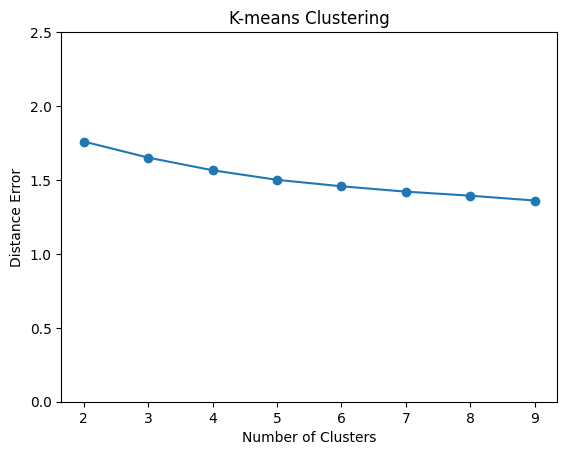

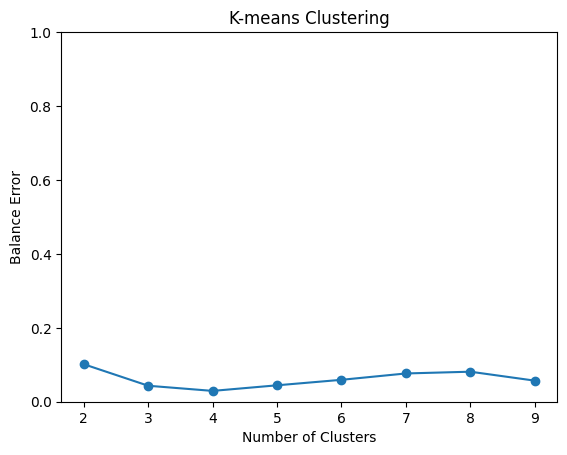

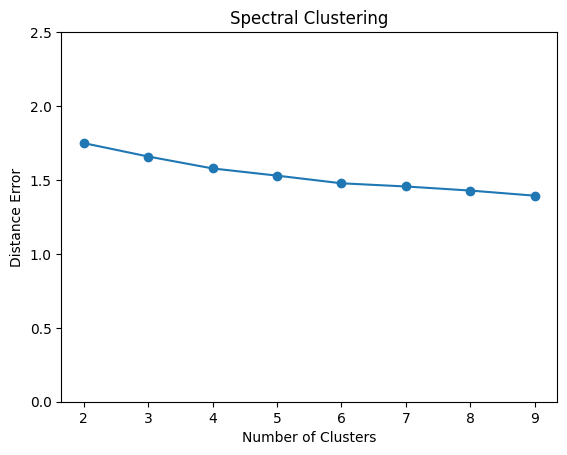

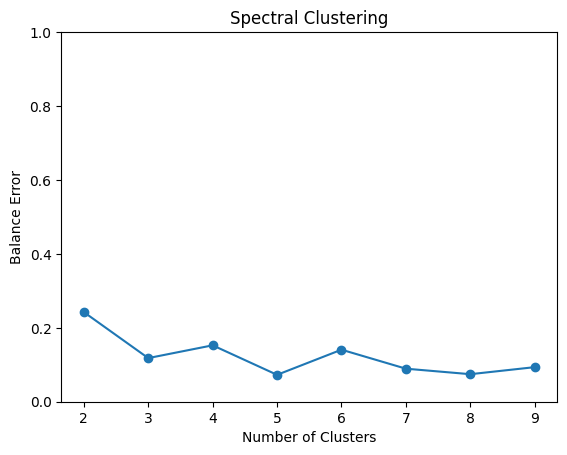

In [8]:
## Plot errors and pick how many cluster
num_clusters = list(range(2,10))

km_dist_err = []
km_like_err = []
km_bala_err = []

sc_dist_err = []
sc_like_err = []
sc_bala_err = []

for n in num_clusters:
  mm = KMeansClustering(n_clusters=n)
  mm.fit_predict(ansur_features)
  km_dist_err.append(mm.distance_error())
  km_bala_err.append(mm.balance_error())

for n in num_clusters:
  mm = SpectralClustering(n_clusters=n)
  mm.fit_predict(ansur_features)
  sc_dist_err.append(mm.distance_error())
  sc_bala_err.append(mm.balance_error())

plt.plot(num_clusters, km_dist_err, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Distance Error")
plt.title("K-means Clustering")
plt.ylim([0, 2.5])
plt.show()

plt.plot(num_clusters, km_bala_err, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Balance Error")
plt.title("K-means Clustering")
plt.ylim([0, 1])
plt.show()

plt.plot(num_clusters, sc_dist_err, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Distance Error")
plt.title("Spectral Clustering")
plt.ylim([0, 2.5])
plt.show()

plt.plot(num_clusters, sc_bala_err, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Balance Error")
plt.title("Spectral Clustering")
plt.ylim([0, 1])
plt.show()

### Interpretation

<span style="color:hotpink;">
Based on the graphs of errors versus number of clusters, does it look like we should change the initial number of clusters ?<br>
How many clusters should we use ? Why ?
</span>

<span style="color:hotpink;">9 clusters have the smallest distance error, 3-5 clusters have the smallest balance error. collectively 9 clusters may be the best to use since balance errors with 9 clusters are only slightly larger</span>

### Revise Number of Clusters.

Re-run with the new number of clusters and plot the data in $2D$ or $3D$.

This can be the same graph as above.

KMeans distance error: 1.3656321184730038
Spectral distance error: 1.3936379256504268
KMeans likelihood error: -4.820786204577573
Spectral likelihood error: -4.8470928697366364
KMeans balance error: 0.05647321428571426
Spectral balance error: 0.09354910714285715


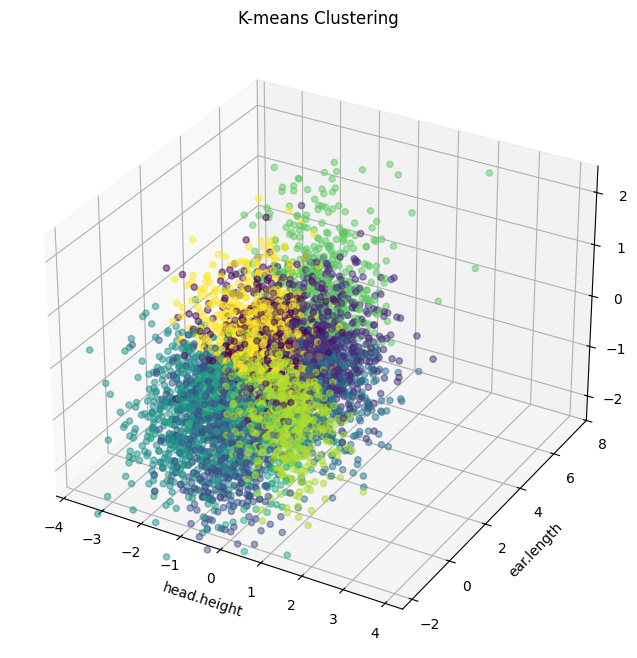

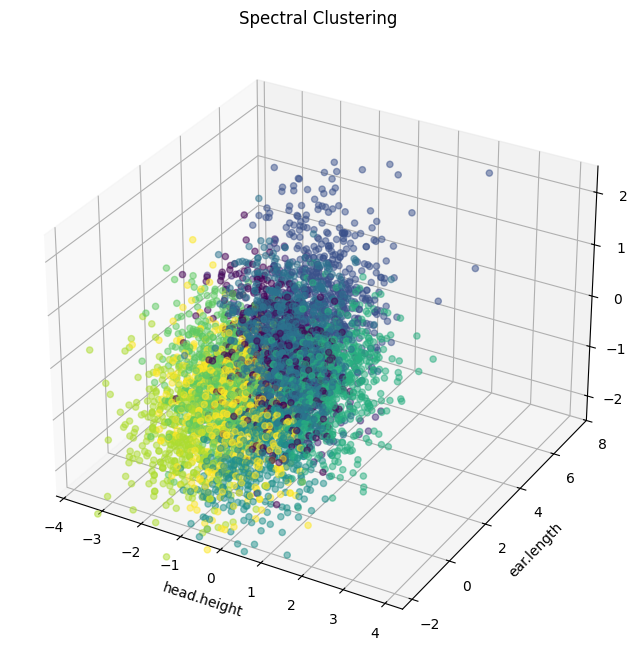

In [9]:
## Re-run clustering with final number of clusters
n_clusters = 9
km_model = KMeansClustering(n_clusters=n_clusters)
sc_model = SpectralClustering(n_clusters = n_clusters)

## Run the model on the training data
km_predicted = km_model.fit_predict(ansur_features)
km_clusters = km_predicted["clusters"]

sc_predicted = sc_model.fit_predict(ansur_features)
sc_clusters = sc_predicted["clusters"]

## Check errors
print("KMeans distance error:", km_model.distance_error())
print("Spectral distance error:", sc_model.distance_error())

print("KMeans likelihood error:", km_model.likelihood_error())
print("Spectral likelihood error:", sc_model.likelihood_error())

print("KMeans balance error:", km_model.balance_error())
print("Spectral balance error:", sc_model.balance_error())

## Plot in 3D
fig_km = plt.figure(figsize=(8, 8))
ax = fig_km.add_subplot(projection='3d')

ax.scatter(x, y, z, c=km_clusters, marker='o', linestyle='', alpha=0.5)

ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_zlabel(zl)

ax.set_ylim(-2.5, 8)
ax.set_zlim(-2.5, 2.5)

plt.title("K-means Clustering")
plt.show()

fig_sc = plt.figure(figsize=(8, 8))
ax = fig_sc.add_subplot(projection='3d')

ax.scatter(x, y, z, c=sc_clusters, marker='o', linestyle='', alpha=0.5)

ax.set_xlabel(xl)
ax.set_ylabel(yl)
ax.set_zlabel(zl)

ax.set_ylim(-2.5, 8)
ax.set_zlim(-2.5, 2.5)

plt.title("Spectral Clustering")
plt.show()

### Interpretation

<span style="color:hotpink;">
Do these look better than the original number of clusters?
</span>

<span style="color:hotpink;">by number all the errors are closer to being a better estimate, by graph it still doesnt look like its making sense</span>

## PCA and Classification

Let's practice doing some more image classification with `PCA` and analyzing the results.

The dataset is the same as last week. It has images from $25$ different security cameras, and our task is to separate them by camera. Some of the cameras move, some of them don't, and there are more than $1000$ images, so there's no way we want to do this by hand.

Let's start by loading the training images into a list of pixels, like we did with the `faces` dataset in class.

### Loading Data

If we look at the images in `./data/images/0801-500/train/`, we'll notice that they are named and organized in a slightly different way. They're all in the same directory and the first part of their filename specifies which camera they came from. Even though those `ids` are numbers, they're not sequential, so we'll use some helper functions to extract a unique `label` from their filenames.

This is exactly what the `OrdinalEncoder` class does, but since we only have to encode this one column, we'll do it by hand while we read the files in.

In [10]:
# this creates a list of all the files in a given directory, that end in .jpg
train_files = [f for f in listdir("./data/images/0801-500/train") if f.endswith(".jpg")]

In [11]:
# TODO: check and see what is inside the list here
print(train_files[:4])

['28-64.jpg', '31-05.jpg', '08-53.jpg', '01-30.jpg']


Now we'll read the image pixels and extract their labels. `CamUtils.get_label()` is the helper function we'll use to "encode" and return a label id based on the filename.

In [12]:
pixel_data = []
label_data = []

for fname in train_files:
  label = CamUtils.get_label(fname)
  img = open_image(path.join("./data/images/0801-500/train", fname))
  pixel_data.append(img.pixels)
  label_data.append(label)

In [13]:
# TODO: check if labels got extracted correctly by looking at 
#       the first few items of the label list and the filename list
print(label_data[:4])
print(train_files[:4])

[23, 24, 6, 0]
['28-64.jpg', '31-05.jpg', '08-53.jpg', '01-30.jpg']


Like last week, the labels and the filenames won't match exactly since labels start at $0$ and the filenames start at $01$ and skip some numbers.

We can open some images from pixels, just to make sure we loaded them correctly:

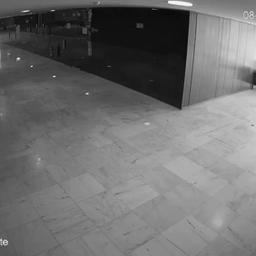

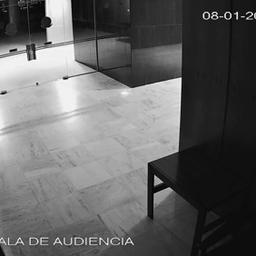

In [14]:
display(make_image(pixel_data[0], width=256))
display(make_image(pixel_data[10], width=256))

### PCA

Create a `DataFrame` called `cam_pca_df` by running `PCA` on the list of pixel data, just like we did in class, and then append a `label` column to it, just like we did last week with: `train_df["label"] = label_data`.

You can change how many components to extract from the images later, but for this first run just use $10$ components so we can compare classification with $10$ `PCA` components to the classification with $10$ random features from `HW08`.  Make sure to confirm how much of the `variance` is preserved by this transformation.

In [15]:
# TODO: run PCA, get DataFrame
cam_pca = PCA(n_components=10)
cam_pca_df = cam_pca.fit_transform(pixel_data)

# TODO: add "label" column
cam_pca_df["label"] = label_data

# TODO: print variance
print(cam_pca.explained_variance())

# TODO: take a look at the first 5 rows
print(cam_pca_df[:5])

0.7852542510230031
            PC0          PC1          PC2          PC3          PC4  \
0   3806.710420 -2697.584968  5286.902807  -732.751032 -4771.198739   
1 -10587.368383  8798.956092 -1936.086107  1612.280460  1735.170794   
2     68.211536  5796.212706  2431.049394  1465.251247 -1569.238447   
3 -10283.276623 -7454.969441  1465.377864 -2144.856967  -776.992442   
4  10706.388370  3114.193836 -2462.939755 -2917.744214  5451.233258   

           PC5          PC6          PC7          PC8          PC9  label  
0  1967.890610 -1745.577310 -2300.473857  1927.844410  -843.638289     23  
1 -1103.647046  -508.971508  2074.617142  1930.293602 -1936.743821     24  
2   349.107103  2258.231847  3556.610569 -1243.031155   942.759922      6  
3 -1890.137504  2315.707085 -1577.256827  -560.011582  -442.333267      0  
4 -3756.883156  1893.647909   265.602104  2477.026295   468.497261     15  


### Interpretation

<span style="color:hotpink">
How many components did you keep ?<br>
Did you try different numbers ?<br>
What percent of variance is kept by this transformation?
</span>

<span style="color:hotpink;">10 components returned 78.5% of the original data. changed it to 30 components and got almost 94%. changed it back to 10 components for the reconstruct because 94% looks too clear to make a comparison with the original</span>

### Reconstruct

Before we go run our classification, let's take a look at some reconstructed images, just to make sure they make sense.

Take a look at reconstructed versions of images $0$, $10$, and whichever other images you might have opened above.

We did this in class. It involves a `inverse_transform()` function.

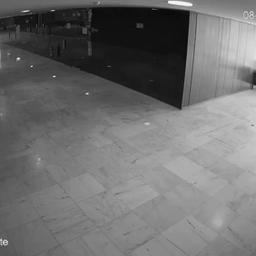

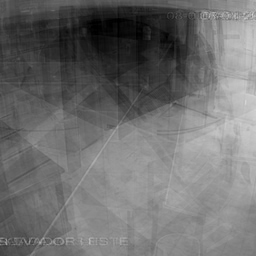

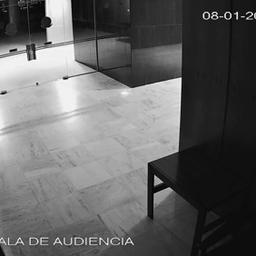

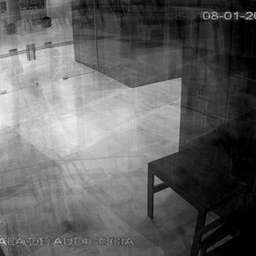

In [16]:
# TODO: reconstruct image at index 0
pca_pixels = cam_pca.inverse_transform(cam_pca_df)
display(make_image(pixel_data[0], width=256))
display(make_image(pca_pixels.loc[0], width=256))

# TODO: reconstruct image at index 10
display(make_image(pixel_data[10], width=256))
display(make_image(pca_pixels.loc[10], width=256))

The reconstructed images should look blurrier and noisier than the original ones, but they should still look something like the original ones.

### Classify !

Train a `RandomForestClassifier` on the `PCA` data.

Remember to separate the output feature (`label`) from the input features (`PC0`, `PC1`, etc).

In [ ]:
# TODO: create a classifier
cam_classifier = RandomForestClassifier()

# TODO: split input and output features
in_features = cam_pca_df.drop(columns=["label"])
out_feature = cam_pca_df["label"]
#print(len(in_features))

# TODO: fit the model
cam_classifier.fit(in_features, out_feature)

# TODO: run predictions
train_predictions = cam_classifier.predict(in_features)

250


### Measure Error

For the train set we could use the generic `classification_error()` function that we've used before because we have the true labels for each file, but for measuring accuracy for our `test` set classification, which has secret labels, we have to use a more specific function from the `CamUtils` class.

The function is called `classification_accuracy()` and it takes $2$ parameters, a list of filenames and the predicted labels associated with those filenames.

The result is an accuracy score ratio, between $0.0$ and $1.0$.

We can run this function on the `train` set as well:

In [23]:
# train_files is the list of files we got way up above
CamUtils.classification_accuracy(train_files, train_predictions)

1.0

### Interpretation

<span style="color:hotpink">
What does this mean?<br>
Should we expect the same result from the test dataset?<br>
Why, or why not?
</span>

<span style="color:hotpink;">all predictions match the training data. not the same result from test because they have different variances(back from answering the next interpretation but not sure if it is correct for either block)</span>

### Run on Test set

Now we'll open the image files inside the `./data/images/0801-500/test/` directory, using almost the exact same steps as we did above to create a `DataFrame` with the exception that we don't have labels for these images.

In [24]:
# TODO: create a list of files in the test/ directory
test_files = [f for f in listdir("./data/images/0801-500/test") if f.endswith(".jpg")]

# TODO: check its length and content
print(len(test_files))

1573


We'll use a similar loop to extract the pixel information from these images, except we don't have `label` data, just pixels.

In [25]:
test_pixel_data = []

for fname in test_files:
  img = open_image(path.join("./data/images/0801-500/test", fname))
  test_pixel_data.append(img.pixels)

Now we can run `PCA` and the `RandomForestClassifier`.

Since those are already trained, all we have to do is run their `transform()` function on the data.

In [ ]:
# TODO: run PCA on test pixels, get DataFrame
#       this is the same PCA that was created above, not a new one
test_pca_df = cam_pca.transform(test_pixel_data)

It's always a good idea to check the result of the `PCA` transformation by looking at the `DataFrame` and reconstructing some images.

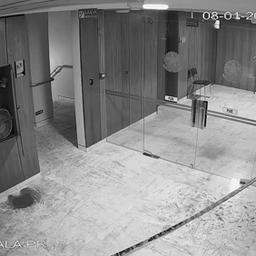

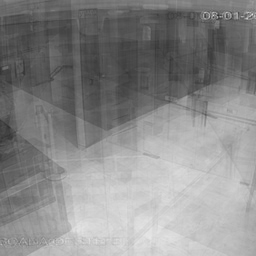

            PC0           PC1           PC2          PC3          PC4  \
0  10756.270379    -80.397187   2766.832441  1225.312040  1468.944039   
1  13404.140244  -7054.936601  -5451.250815 -1001.524886   972.399056   
2   7842.585261  -6936.565261   3573.030863 -3847.971452 -2020.064339   
3   6199.413679   3318.375679 -13466.048300 -3065.248992 -3172.224981   
4  -8031.523793 -16438.196109  -3035.505923  3891.619287  3036.934233   

           PC5          PC6          PC7          PC8          PC9  
0   109.003841 -3006.395927  1898.269465   -64.043661  -741.465787  
1   287.050638  -979.925633 -1271.739560 -1206.094811  2352.317444  
2   345.010253 -3191.599245  5558.676531  1344.601075 -3737.162299  
3  2329.323266 -1747.085461 -1934.485808   202.867339 -2645.453786  
4 -1067.607533  3196.023287  -783.359608  2479.901821   758.822927  


In [28]:
# TODO: reconstruct one or two images
test_pca_pixels = cam_pca.inverse_transform(test_pca_df)
display(make_image(test_pixel_data[0], width=256))
display(make_image(test_pca_pixels.loc[0], width=256))

# TODO: take a look at the first 5 rows
print(test_pca_df[:5])

### Interpretation

<span style="color:hotpink"><br>
The reconstructed images from the `test` set will always be noisier than the `train` images.<br><br>
Why?<br><br>
</span>

<span style="color:hotpink;">because test data has different variance than the train data variance that was used to train the model so the percentage retained would be different</span>



Run the classifier and get predicted labels. Then get its accuracy ratio is by running the `CamUtils.classification_accuracy()` function with the list of filenames and list of predictions.

In [31]:
# TODO: run classifier. This is the same classifier already fitted on the train data above
test_predicted = cam_classifier.predict(test_pca_df)

# TODO: get accuracy
CamUtils.classification_accuracy(test_files, test_predicted)

0.9230769230769231

### Interpretation

<span style="color:hotpink">
What's the accuracy ? How could we improve that if we wanted ?<br>
How does this compare to last week's classification model? They can both be tuned to perform well, but how many features did we need last week to get an accuracy comparable to this?
</span>

<span style="color:hotpink;">the same classifier from the train data set has an accuracy of 0.92 on the test data which is higher than the model in hw8. for hw8 i used 100 features for an accuracy of 0.84. with pca the number of input features are 250(checked above and commented out)</span>